In [1]:
import glob
import torch
import os
import math
import numpy as np

from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

from utils.image_helpers import plot_image_grid, rgb2gray
from utils.evaluation_helpers import vifp_mscale, calculate_model_performances, calculate_noisy_performance, split_performances
from utils.pickle_utils import load_results
from fitting.Result import calculate_combination_results

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def get_most_recent_gridsearch():
    file_paths = glob.glob("data/results/*gridsearch.pkl")
    file_paths.sort()
    return file_paths[-1]

# Load Results

In [3]:
#most recent
file_path = get_most_recent_gridsearch()

#canonical
file_path = 'data/results/2020-11-12-08:18-gridsearch.pkl'

#cameraman
file_path = 'data/results/2020-11-11-16:35-gridsearch.pkl'

# 20 ImageNet v2 Images with deep
#file_path = 'data/results/2020-11-16-17:53-gridsearch.pkl'


results = load_results(file_path)
print(file_path)
print('Number of Runs loaded:', len(results))

for result in results:
    result.best_loss_wrt_noisy = result.best_loss_wrt_noisy.cpu()

data/results/2020-11-11-16:35-gridsearch.pkl
Number of Runs loaded: 144


In [4]:
#number_of_images = math.floor(len(results)/600)
#results = results[:number_of_images*600]

# Show Images

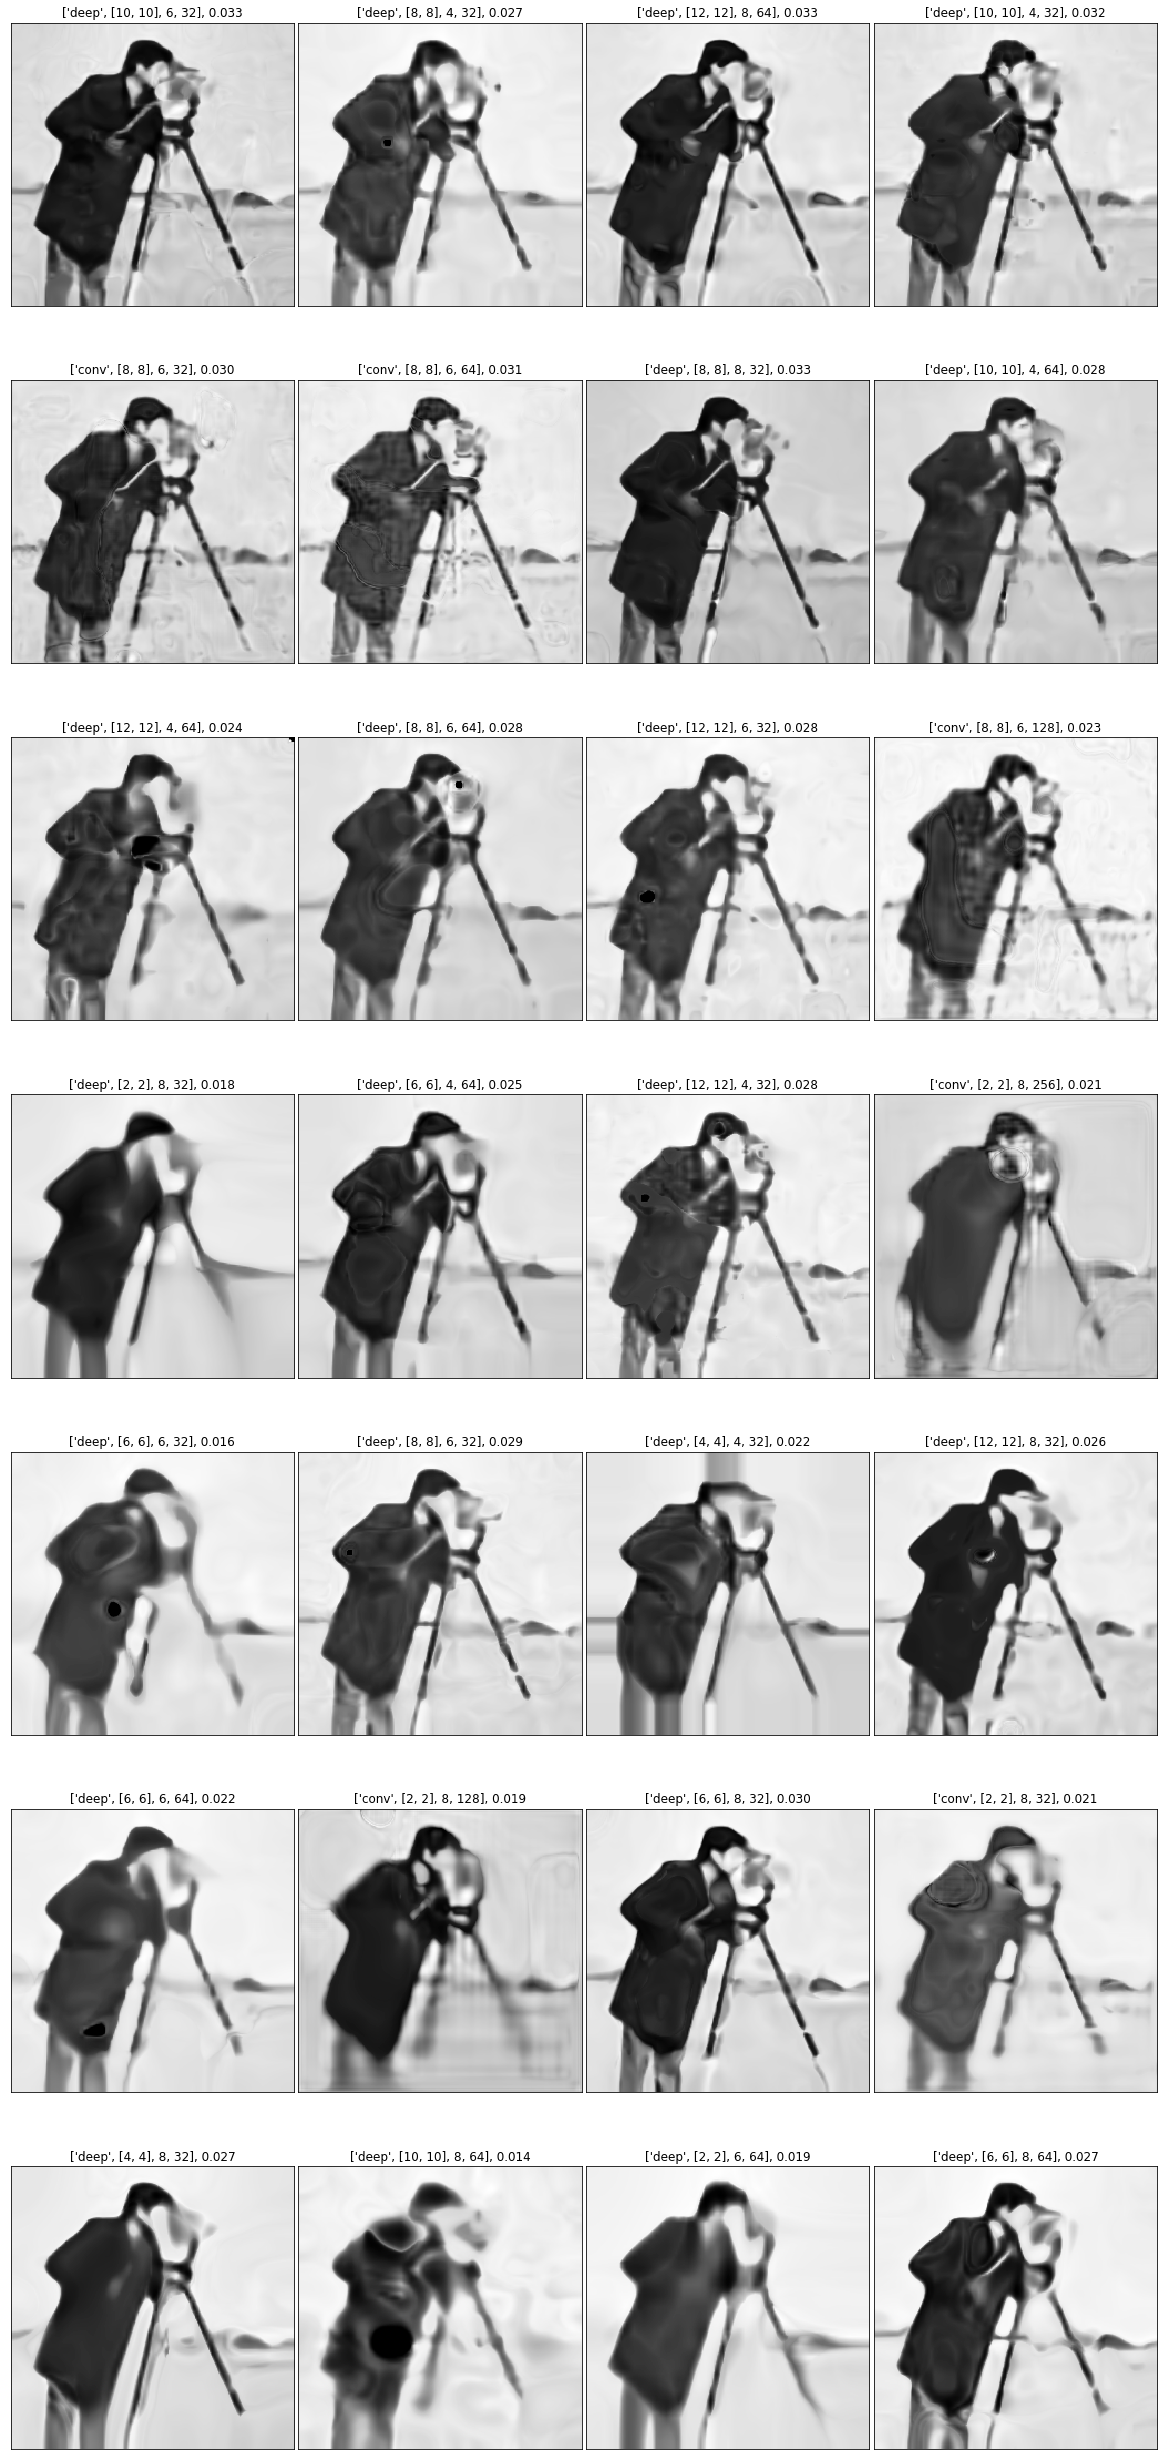

In [5]:
results.sort(key=lambda x: x.loss_wrt_target, reverse=False)
images = list(map(lambda x: x.model_image, results))[:28]
descriptions = list(map(lambda x: str(x.model_parameters) + f', {x.vif:.3f}', results))[:28]

noisy_performance = calculate_noisy_performance(results)

plot_image_grid(images, descriptions, ncols=4)
plt.show()

# Reduce results to best per setting

In [6]:
average_performances = calculate_model_performances(results)
filtered_performances = filter(lambda x: x['psnr'] > 23.0, average_performances)

# Plot different parameter combinations

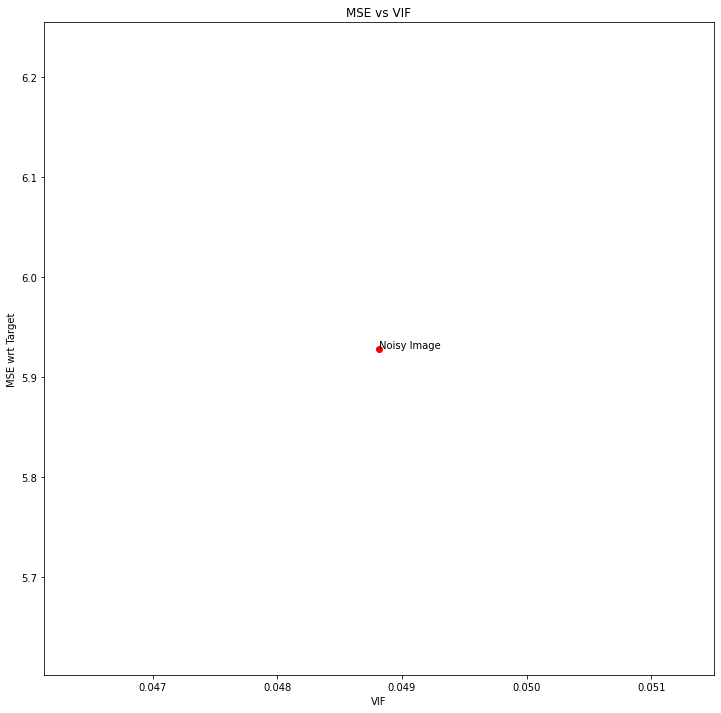

In [7]:
plt.figure(figsize=(12,12))
for performance in filtered_performances:
    plt.scatter(performance['vif'], performance['psnr'], c='gray')
    plt.annotate(str(performance['description']), (performance['vif'], performance['psnr']))
plt.scatter(noisy_performance['vif'], noisy_performance['psnr'], c='red')
plt.annotate('Noisy Image', (noisy_performance['vif'], noisy_performance['psnr']))
plt.xlabel('VIF')
plt.ylabel('MSE wrt Target')
plt.title('MSE vs VIF')
plt.show()

# Visualize different archichtecture parameters

In [8]:
type_performances = split_performances(average_performances, split_type='model_type')
input_performances = split_performances(average_performances, split_type='input_shape')
layer_performances = split_performances(average_performances, split_type='number_of_layers')
channel_performances = split_performances(average_performances, split_type='number_of_channels')

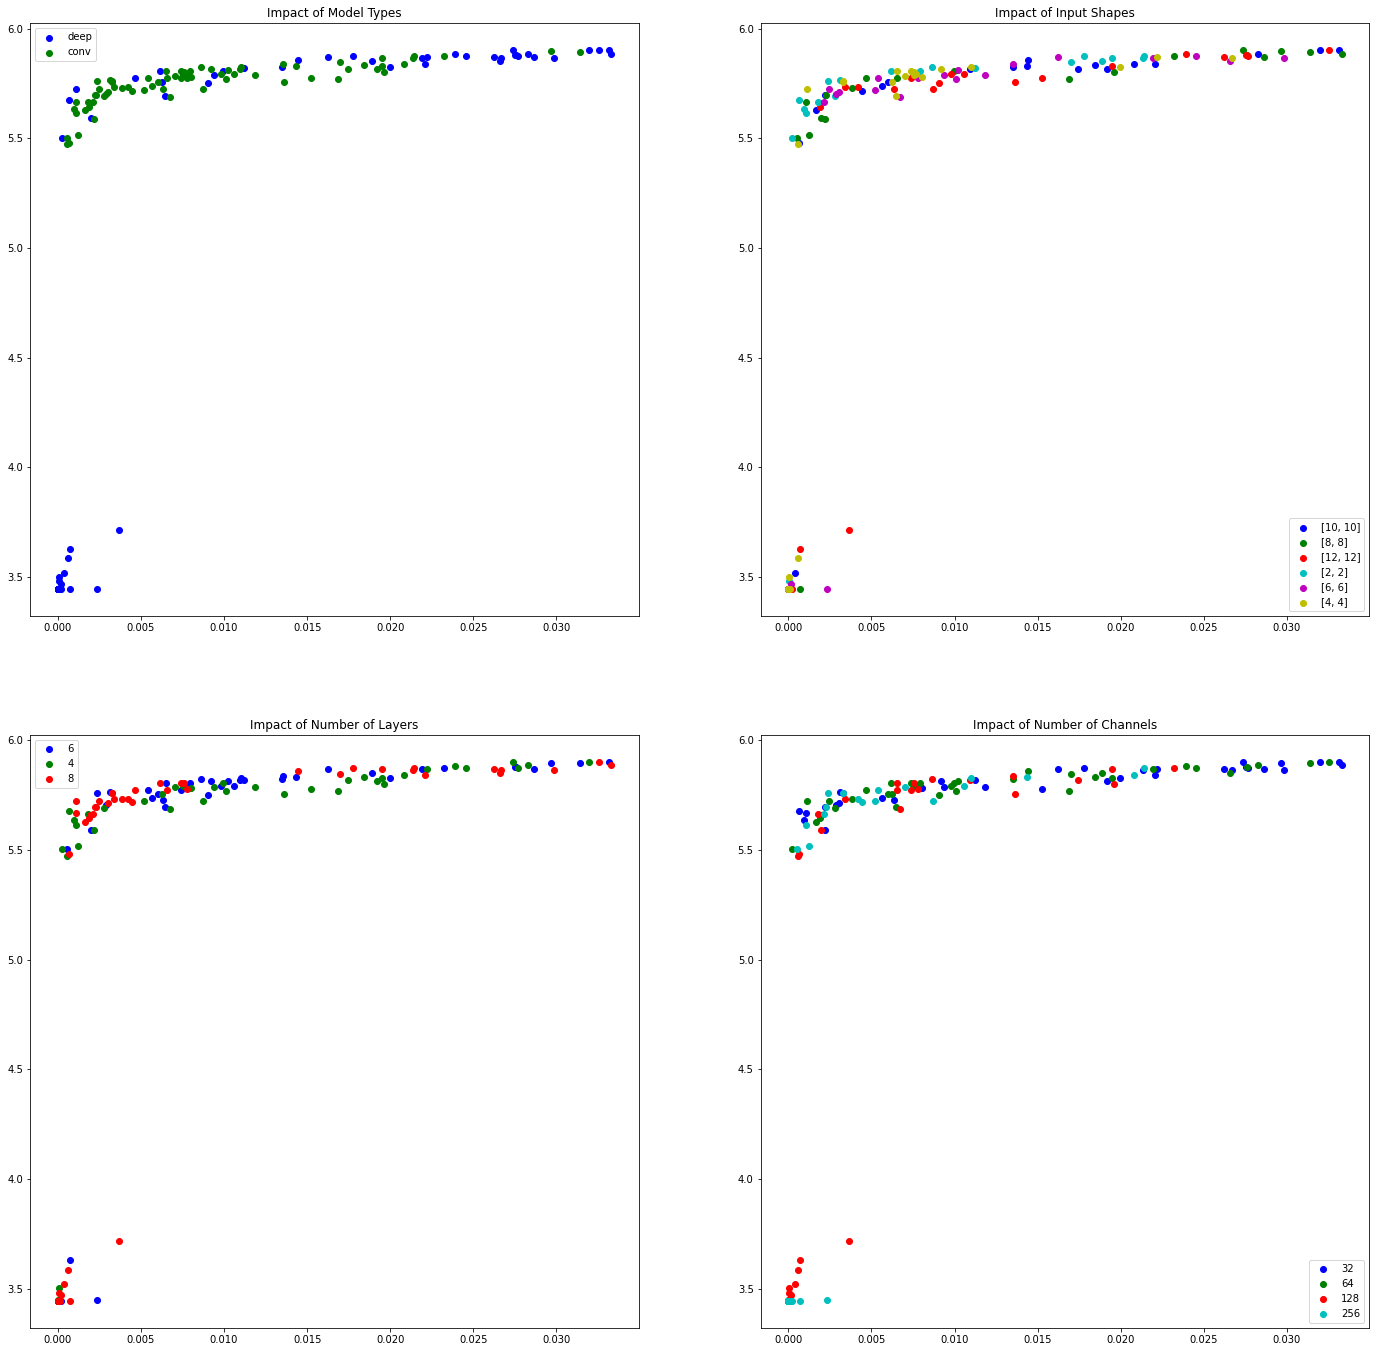

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
figure, axes = plt.subplots(2, 2, figsize=(24,24))

x = 'vif'
y = 'psnr'

for index, performances_key in enumerate(type_performances):
    x_list = [performance[x] for performance in type_performances[performances_key]]
    y_list = [performance[y] for performance in type_performances[performances_key]]
    axes[0][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][0].legend()
    axes[0][0].set_title('Impact of Model Types')
for index, performances_key in enumerate(input_performances):
    x_list = [performance[x] for performance in input_performances[performances_key]]
    y_list = [performance[y] for performance in input_performances[performances_key]]
    axes[0][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[0][1].legend()
    axes[0][1].set_title('Impact of Input Shapes')
for index, performances_key in enumerate(layer_performances):
    x_list = [performance[x] for performance in layer_performances[performances_key]]
    y_list = [performance[y] for performance in layer_performances[performances_key]]
    axes[1][0].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][0].legend()
    axes[1][0].set_title('Impact of Number of Layers')
for index, performances_key in enumerate(channel_performances):
    x_list = [performance[x] for performance in channel_performances[performances_key]]
    y_list = [performance[y] for performance in channel_performances[performances_key]]
    axes[1][1].scatter(x_list, y_list, c=colors[index], label=performances_key)
    axes[1][1].legend()
    axes[1][1].set_title('Impact of Number of Channels')

# Combination of different runs

In [10]:
def choose_noisy(results):
    return results[0].noisy_image

def average_images(results):
    images_to_combine = [x.model_image for x in results]
    return np.mean(images_to_combine, axis=0)

def average_images_and_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def median_images(results):
    images_to_combine = [x.model_image for x in results]
    return np.median(images_to_combine, axis=0)

def median_images_and_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    return np.median(images_to_combine, axis=0)

def average_images_and_more_noisy(results):
    images_to_combine = [x.model_image for x in results]
    images_to_combine.append(results[0].noisy_image)
    images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def average_images_and_even_more_noisy(results):
    images_to_combine = [x.model_image for x in results]
    for _ in range(5):
        images_to_combine.append(results[0].noisy_image)
    return np.mean(images_to_combine, axis=0)

def weighted_average(results):
    weights = np.array([1/x.best_loss_wrt_noisy for x in results])
    weights = weights/np.sum(weights)
    images_to_combine = [x.model_image for x in results]
    return np.average(images_to_combine, axis=0, weights=weights)

functions = {'Noisy Baseline': choose_noisy, 
             'Average Images': average_images, 
             #'Average with Noisy': average_images_and_noisy, 
             #'Median Images': median_images, 
             #'Median with Noisy': median_images_and_noisy,
             #'Average with more Noisy': average_images_and_more_noisy,
             'Average with even more Noisy': average_images_and_even_more_noisy,
             'Weighted Average': weighted_average
            }

for function in functions:
    print(function)

Noisy Baseline
Average Images
Average with even more Noisy
Weighted Average


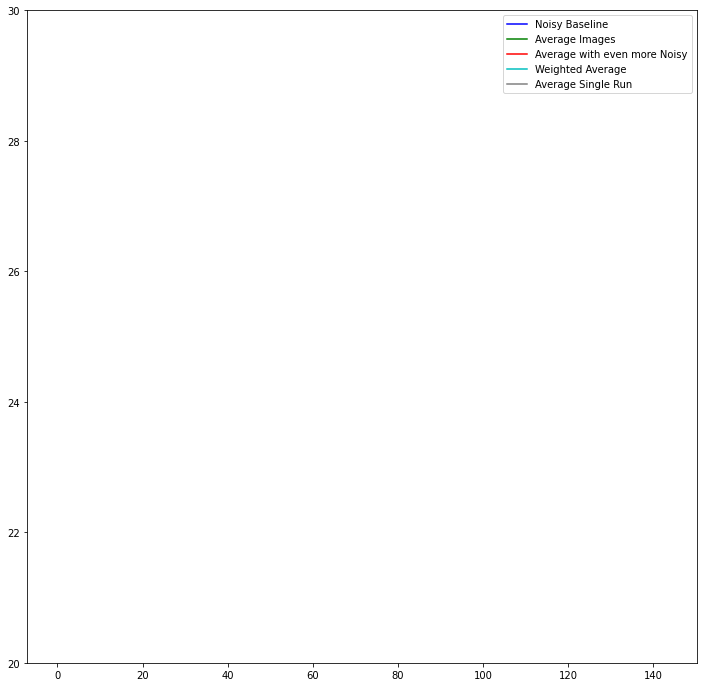

In [11]:
all_performances = {}
for function in functions:
    new_results = calculate_combination_results(results, image_from_results=functions[function])
    performances = calculate_model_performances(new_results)
    performances.sort(key=lambda x: str(x['description']))
    all_performances[function] = performances

parameter='psnr'
plt.figure(figsize=(12,12))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for index, function in enumerate(all_performances):
    plt.plot([x[parameter] for x in all_performances[function]], c=colors[index], label=function)
plt.plot([x[parameter] for x in average_performances], c='gray', label='Average Single Run')

if parameter == 'psnr':
    plt.ylim(20, 30)
plt.legend()
plt.show()